# Packages

In [41]:
# Data manipulation and stats
import pandas as pd
import numpy as np
import seaborn as sns
import time
from scipy.stats import zscore

# Imputation
from sklearn.experimental import enable_iterative_imputer  # must come before IterativeImputer
from sklearn.impute import IterativeImputer

# Modeling and pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

# Metrics and model evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report
)

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from plotnine import (
    ggplot, aes, geom_boxplot, geom_jitter, geom_point, geom_line, geom_segment,
    geom_histogram, geom_errorbar, facet_wrap,
    theme_bw, theme_minimal, theme, element_text,
    scale_color_manual, scale_fill_manual, scale_y_continuous,
    coord_cartesian, geom_vline, labs
)



# Data

## Download

In [42]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = [
    "pregna", "glucos", "bpresr", "skinth", 
    "insuli", "bmi", "diabpd", "age", "outcome"
]

df = pd.read_csv(url, header=None, names=cols)
print(df.head())

   pregna  glucos  bpresr  skinth  insuli   bmi  diabpd  age  outcome
0       6     148      72      35       0  33.6   0.627   50        1
1       1      85      66      29       0  26.6   0.351   31        0
2       8     183      64       0       0  23.3   0.672   32        1
3       1      89      66      23      94  28.1   0.167   21        0
4       0     137      40      35     168  43.1   2.288   33        1


## Summarize

In [43]:
summary = df.describe().T
summary['median'] = df.median()
summary['skew'] = df.skew()
summary['kurt'] = df.kurtosis()
summary[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurt']]

,count,mean,median,std,min,25%,50%,75%,max,skew,kurt
pregna,768.0,3.845052,3.0000,3.369578,0.000,1.00000,3.0000,6.00000,17.00,0.901674,0.159220
glucos,768.0,120.894531,117.0000,31.972618,0.000,99.00000,117.0000,140.25000,199.00,0.173754,0.640780
bpresr,768.0,69.105469,72.0000,19.355807,0.000,62.00000,72.0000,80.00000,122.00,-1.843608,5.180157
skinth,768.0,20.536458,23.0000,15.952218,0.000,0.00000,23.0000,32.00000,99.00,0.109372,-0.520072
insuli,768.0,79.799479,30.5000,115.244002,0.000,0.00000,30.5000,127.25000,846.00,2.272251,7.214260
bmi,768.0,31.992578,32.0000,7.884160,0.000,27.30000,32.0000,36.60000,67.10,-0.428982,3.290443
diabpd,768.0,0.471876,0.3725,0.331329,0.078,0.24375,0.3725,0.62625,2.42,1.919911,5.594954
age,768.0,33.240885,29.0000,11.760232,21.000,24.00000,29.0000,41.00000,81.00,1.129597,0.643159
outcome,768.0,0.348958,0.0000,0.476951,0.000,0.00000,0.0000,1.00000,1.00,0.635017,-1.600930


## Check Outliers

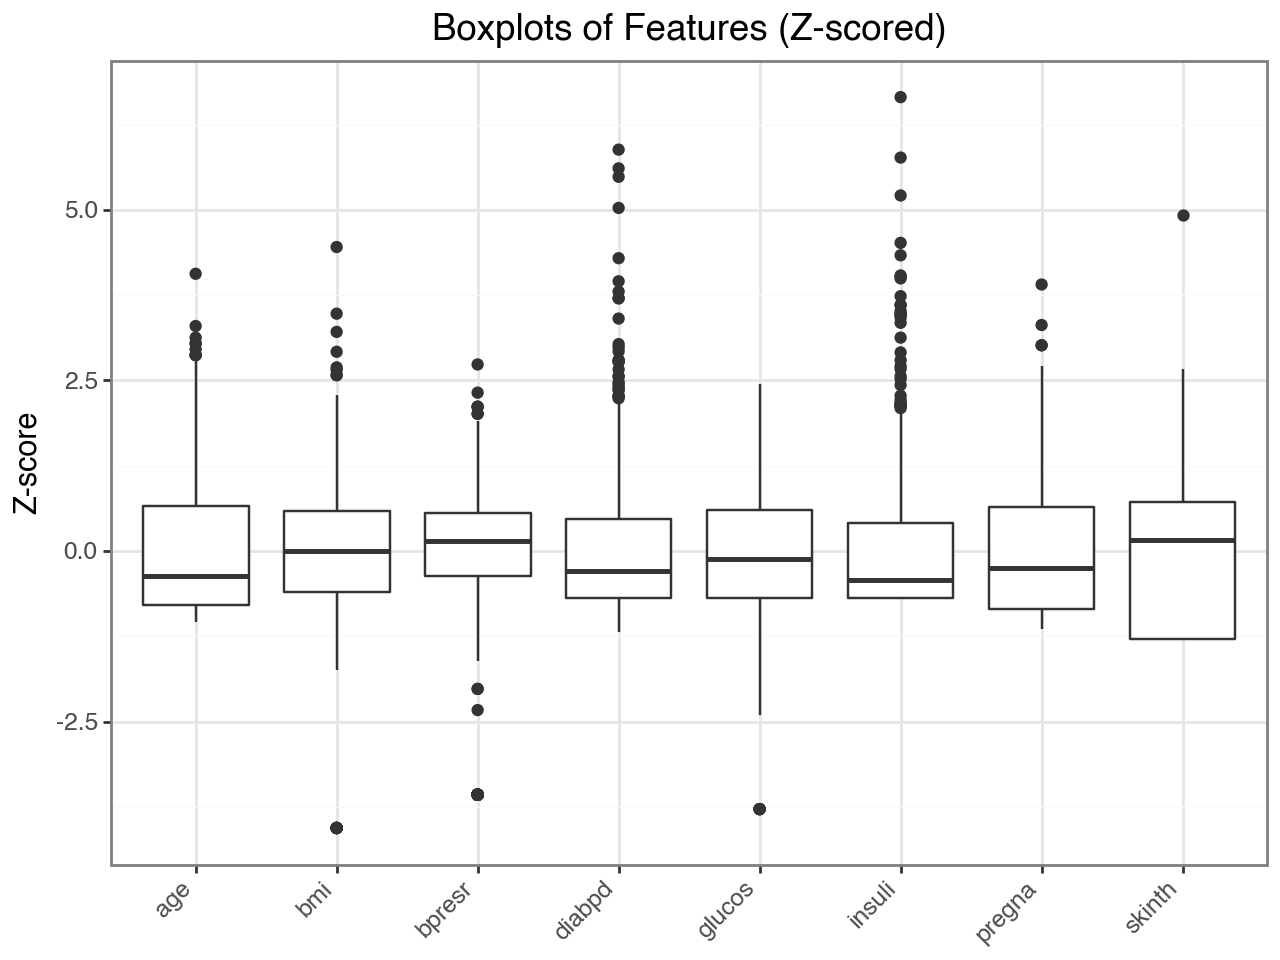

In [44]:
features = df.columns.drop('outcome')
df_z = df[features].apply(zscore)

# Prepare your data in a tidy format
df_z_melted = df_z.melt(var_name='Feature', value_name='Z_score')

# ggplot style plot
(
    ggplot(df_z_melted, aes(x='Feature', y='Z_score'))
    + geom_boxplot()
    + theme_bw()
    + labs(title='Boxplots of Features (Z-scored)', y='Z-score', x='')
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

## Count NAs

In [45]:
cols_with_zeros = ["glucos", "bpresr", "skinth", "insuli", "bmi"]
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
print(df.isna().sum())

pregna       0
glucos       5
bpresr      35
skinth     227
insuli     374
bmi         11
diabpd       0
age          0
outcome      0
dtype: int64


## Summarize with NAs

In [46]:
summary = df.describe().T
summary['median'] = df.median()
summary['skew'] = df.skew()
summary['kurt'] = df.kurtosis()
summary[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurt']]

,count,mean,median,std,min,25%,50%,75%,max,skew,kurt
pregna,768.0,3.845052,3.0000,3.369578,0.000,1.00000,3.0000,6.00000,17.00,0.901674,0.159220
glucos,763.0,121.686763,117.0000,30.535641,44.000,99.00000,117.0000,141.00000,199.00,0.530989,-0.277040
bpresr,733.0,72.405184,72.0000,12.382158,24.000,64.00000,72.0000,80.00000,122.00,0.134153,0.911158
skinth,541.0,29.153420,29.0000,10.476982,7.000,22.00000,29.0000,36.00000,99.00,0.690619,2.935491
insuli,394.0,155.548223,125.0000,118.775855,14.000,76.25000,125.0000,190.00000,846.00,2.166464,6.370522
bmi,757.0,32.457464,32.3000,6.924988,18.200,27.50000,32.3000,36.60000,67.10,0.593970,0.863379
diabpd,768.0,0.471876,0.3725,0.331329,0.078,0.24375,0.3725,0.62625,2.42,1.919911,5.594954
age,768.0,33.240885,29.0000,11.760232,21.000,24.00000,29.0000,41.00000,81.00,1.129597,0.643159
outcome,768.0,0.348958,0.0000,0.476951,0.000,0.00000,0.0000,1.00000,1.00,0.635017,-1.600930


## Boxplot NAs

/Users/rkw/miniconda3/lib/python3.13/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 652 rows containing non-finite values.


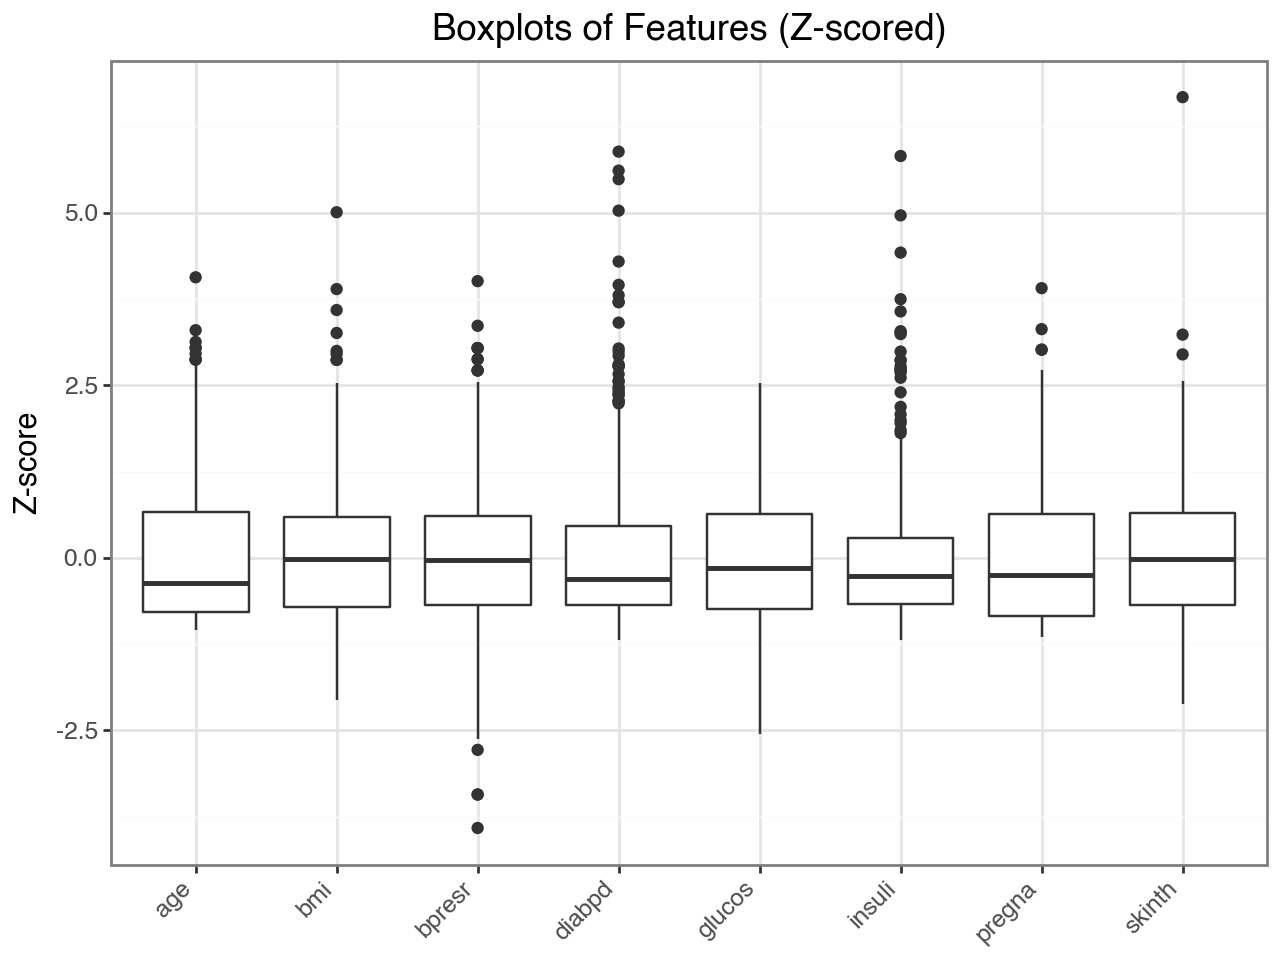

In [47]:
features = df.columns.drop('outcome')
df_z = df[features].apply(lambda x: zscore(x, nan_policy='omit'))

# Reshape data to long format
df_z_long = df_z.melt(var_name='Feature', value_name='Z_score')

# Plot using ggplot style
(
    ggplot(df_z_long, aes(x='Feature', y='Z_score')) +
    geom_boxplot() +
    labs(title='Boxplots of Features (Z-scored)', y='Z-score', x='') +
    theme_bw() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)


## Count Outliers

In [48]:
outliers_count = (df_z.abs() > 3).sum()
print(outliers_count)

pregna     4
glucos     0
bpresr     8
skinth     2
insuli     8
bmi        4
diabpd    11
age        5
dtype: int64


In [49]:
df_no_outliers = df.copy()
df_no_outliers[df_z.abs() > 3] = np.nan

## Count NAs + Outliers

In [50]:
print(df_no_outliers.isna().sum())

pregna       4
glucos       5
bpresr      43
skinth     229
insuli     382
bmi         15
diabpd      11
age          5
outcome      0
dtype: int64


# Data Imputed

In [51]:
X = df_no_outliers.drop(columns="outcome")
y = df_no_outliers["outcome"]

imp = IterativeImputer(max_iter=10, sample_posterior=True, random_state=0)

X_imputed = imp.fit_transform(X)

df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
df_imputed["outcome"] = y

df_imputed.isna().sum()

pregna     0
glucos     0
bpresr     0
skinth     0
insuli     0
bmi        0
diabpd     0
age        0
outcome    0
dtype: int64

## Summarize

In [52]:
summary = df_imputed.describe().T
summary['median'] = df_imputed.median()
summary['skew'] = df_imputed.skew()
summary['kurt'] = df_imputed.kurtosis()
summary[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurt']]

,count,mean,median,std,min,25%,50%,75%,max,skew,kurt
pregna,768.0,3.799799,3.000000,3.275800,0.000000,1.000000,3.000000,6.000000,13.000000,0.811901,-0.175667
glucos,768.0,121.674743,117.000000,30.479295,44.000000,99.000000,117.000000,141.000000,199.000000,0.531071,-0.272082
bpresr,768.0,72.213006,72.000000,11.554721,38.000000,64.000000,72.000000,80.000000,108.000000,0.105952,0.033951
skinth,768.0,28.677429,29.000000,9.903775,6.585528,21.602076,29.000000,35.119019,60.424048,0.193956,-0.274589
insuli,768.0,143.159587,128.525842,103.180473,-149.925317,74.700109,128.525842,200.000000,527.052349,0.718126,1.106500
bmi,768.0,32.370132,32.250000,6.664361,18.200000,27.500000,32.250000,36.600000,53.200000,0.351737,-0.179500
diabpd,768.0,0.451401,0.368000,0.280351,0.078000,0.243750,0.368000,0.612250,1.461000,1.156328,0.994828
age,768.0,33.004444,29.000000,11.359138,17.486139,24.000000,29.000000,40.000000,68.000000,1.043316,0.294894
outcome,768.0,0.348958,0.000000,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000,0.635017,-1.600930


## Boxplot Outliers

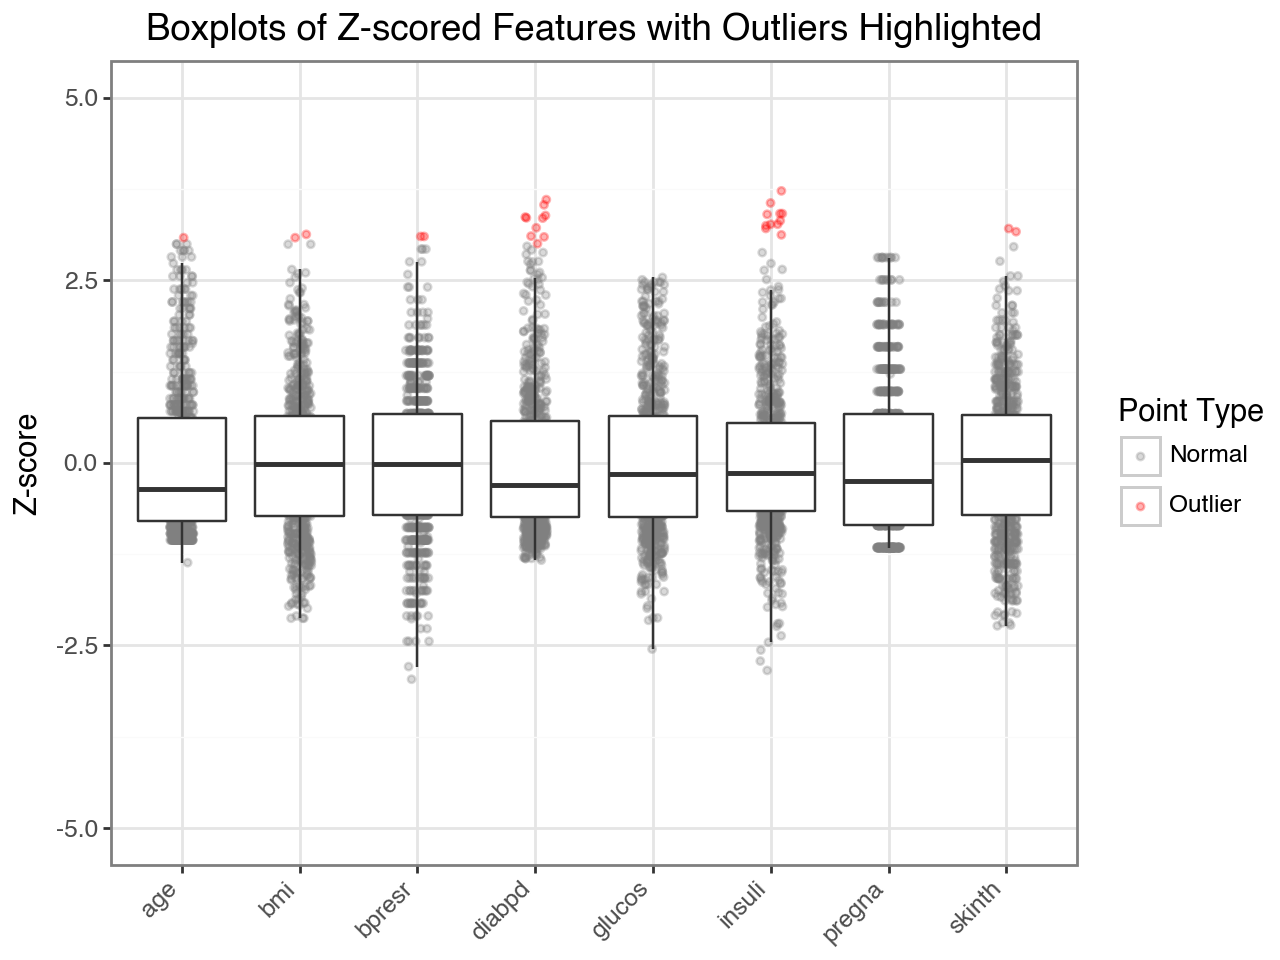

In [53]:
# Compute z‐scores for each predictor
df_z = df_imputed.drop(columns='outcome').apply(zscore)

# Reshape to long format
df_z_long = df_z.melt(var_name='Feature', value_name='Z_score')

# Flag outliers
threshold = 3
df_z_long['Outlier'] = np.where(abs(df_z_long['Z_score']) > threshold, 'Outlier', 'Normal')

# ggplot-style plot
(
    ggplot(df_z_long, aes(x='Feature', y='Z_score'))
    + geom_jitter(aes(color='Outlier'), width=0.1, alpha=0.3, size=1)
    + geom_boxplot(outlier_shape=None)
    + scale_color_manual(values={'Normal': 'grey', 'Outlier': 'red'})
    + labs(title='Boxplots of Z‐scored Features with Outliers Highlighted',
           y='Z‐score', x='', color='Point Type')
    + coord_cartesian(ylim=(-5, 5))
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

## Correlogram

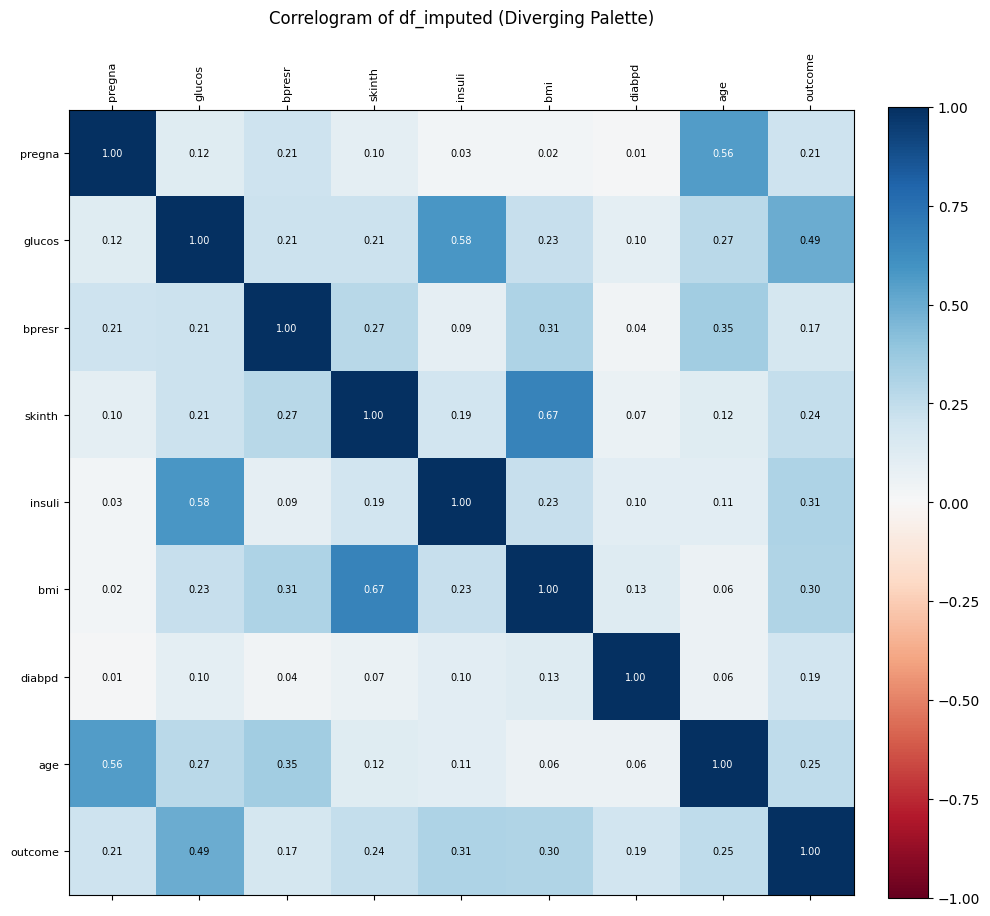

In [54]:
# Recompute if necessary
corr = df_imputed.corr()

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

ticks = np.arange(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr.index, fontsize=8)

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        val = corr.iloc[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        ax.text(j, i, f"{val:.2f}", va='center', ha='center', color=color, fontsize=7)

ax.set_title("Correlogram of df_imputed (Diverging Palette)", pad=20)
plt.tight_layout()
plt.show()


# Model

## Split

In [55]:
X = df_imputed.drop(columns="outcome")
y = df_imputed["outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Logistic Regression

### Baseline Model

In [56]:
baseline = LogisticRegression(max_iter=1000, random_state=42)
baseline.fit(X_train, y_train)

y_pred_base  = baseline.predict(X_test)
y_proba_base = baseline.predict_proba(X_test)[:,1]

print("Baseline Acc:", accuracy_score(y_test, y_pred_base))
print("Baseline AUC:", roc_auc_score(y_test, y_proba_base))

Baseline Acc: 0.7012987012987013
Baseline AUC: 0.8072222222222222


### Hyperparameter Tuning (5-fold CV on training data)

In [57]:
# Build pipeline: scaling + logistic regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])

# Parameter grid for hyperparameter tuning
param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
    "clf__solver": ["liblinear", "saga"],
    "clf__class_weight": [None, "balanced"]
}

# GridSearchCV: 5-fold CV, ROC AUC scoring
lr_grid = GridSearchCV(
    pipe, param_grid,
    cv=5, scoring="roc_auc",
    n_jobs=-1, verbose=1
)

# Fit on training data
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

### Best Parameters

In [58]:
# ─── Cell 16: Inspect Grid Search Results ────────────────────────────────────
print("Best parameters found:", lr_grid.best_params_)
print("Best cross-validated ROC AUC:", lr_grid.best_score_)

Best parameters found: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best cross-validated ROC AUC: 0.8423158914728681


### Final Model Training (refit on full training set)

In [59]:
# ─── Cell 17: Evaluate Best Model on Test Set ───────────────────────────────
best_model = lr_grid.best_estimator_

y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc_tuned = accuracy_score(y_test, y_pred)
auc_tuned = roc_auc_score(y_test, y_proba)

print("Test Accuracy:    ", accuracy_score(y_test, y_pred))
print("Test ROC AUC:     ", roc_auc_score(y_test, y_proba))

Test Accuracy:     0.7467532467532467
Test ROC AUC:      0.8053703703703704


### Confusion Matrix

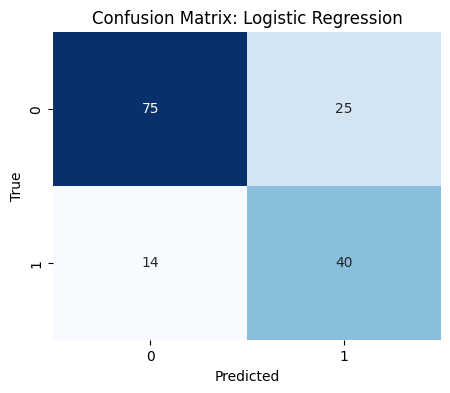

In [60]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=[0, 1], yticklabels=[0, 1]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

## Random Forest

### Baseline Model

In [61]:
# ─── Cell 19: Train & evaluate a Random Forest ────────────────────────────────
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# 1) Instantiate
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'   # to mirror your tuning on class weights
)

# 2) Fit on the same train / test split
rf.fit(X_train, y_train)

# 3) Predict & score
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

#-------------rf benchmark ------------------------------
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"RF  Benchmark Accuracy: {acc_rf:.3f}")
print(f"RF  Benchmark ROC AUC:  {auc_rf:.3f}")

RF  Benchmark Accuracy: 0.721
RF  Benchmark ROC AUC:  0.813


### Hyperparameter Tuning (5-fold CV on training data)

In [62]:
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

rf_param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", 0.5]
}

rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 5, 10, 20],
                         'clf__max_features': ['sqrt', 'log2', 0.5],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=1)

### Best Parameters


In [63]:
print("Best RF params:", rf_grid.best_params_)
print("Best RF CV AUC:", rf_grid.best_score_)

Best RF params: {'clf__max_depth': 5, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}
Best RF CV AUC: 0.8376910299003322


### Final Model Training (refit on full training set)

In [64]:
# best_rf_pipe is a Pipeline that was refit on all of X_train
best_rf_pipe = rf_grid.best_estimator_

# (2) Evaluate on the test set
y_pred_rf  = best_rf_pipe.predict(X_test)
y_proba_rf = best_rf_pipe.predict_proba(X_test)[:, 1]

# (3) Compute metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("RF Test Accuracy: ", acc_rf)
print("RF Test ROC AUC:  ", auc_rf)

RF Test Accuracy:  0.7662337662337663
RF Test ROC AUC:   0.8187037037037037


### Confusion Matrix

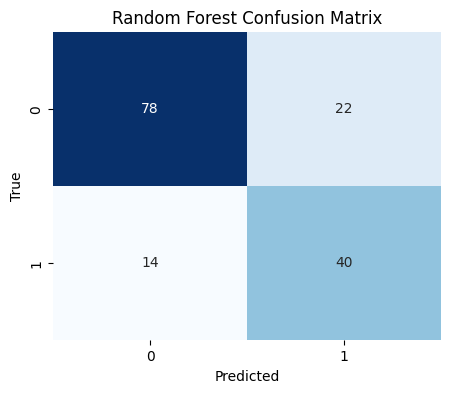

In [65]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])

# Plot with seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=[0, 1], yticklabels=[0, 1]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

## XGBoost

### Baseline Model

In [66]:
# (1) Instantiate with default settings
xgb_baseline = XGBClassifier(
    random_state=42,
    eval_metric="logloss"       
)

# (2) Fit on the full training set
xgb_baseline.fit(X_train, y_train)

# (3) Predict on the test set
y_pred_xgb  = xgb_baseline.predict(X_test)
y_proba_xgb = xgb_baseline.predict_proba(X_test)[:, 1]

# (4) Print basic metrics
print("XGB Test Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("XGB Test ROC AUC:  ", roc_auc_score(y_test, y_proba_xgb))

XGB Test Accuracy:  0.7597402597402597
XGB Test ROC AUC:   0.8238888888888889


### Hyperparameter Tuning (5-fold CV or on training data)

In [67]:
# 1) Build the pipeline
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        random_state=42,
        eval_metric="logloss"
    ))
])

# 2) Define the grid of hyper-parameters
param_grid_xgb = {
    "clf__n_estimators":      [50, 100, 200],
    "clf__max_depth":         [3, 5, 7],
    "clf__learning_rate":     [0.01, 0.1, 0.2],
    "clf__subsample":         [0.6, 0.8, 1.0],
    "clf__colsample_bytree":  [0.6, 0.8, 1.0],
    # adjust for class imbalance if needed:
    "clf__scale_pos_weight":  [1, (y_train==0).sum()/(y_train==1).sum()]
}

# 3) Set up and run GridSearchCV
xgb_grid = GridSearchCV(
    xgb_pipe,
    param_grid_xgb,
    cv=5,               # 5-fold CV
    scoring="roc_auc",  # optimize for AUC
    n_jobs=-1,
    verbose=1,
    refit=True
)

# 4) Fit on the training data
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_poli...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__learning_rate': [0.01, 0.1, 0.2],
                         'clf__max_depth': [3, 5, 7],
                         'clf__n_estimators': [50, 100, 200],
                         'clf__scale_pos_weight': [1,
                                                   np.float64(1.8691588785046729)],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

### Best Parameters

In [68]:
# 5) View your best parameters
print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB CV AUC:  ", xgb_grid.best_score_)

Best XGB params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.6}
Best XGB CV AUC:   0.8358471760797341


### Final Model Training (refit on full training set)

In [69]:
# Pull out the refit pipeline (already trained on all of X_train)
best_xgb = xgb_grid.best_estimator_

# (Optional) Explicitly refit on full training set
best_xgb.fit(X_train, y_train)

# (2) Predict on test set
y_pred_xgb   = best_xgb.predict(X_test)
y_proba_xgb  = best_xgb.predict_proba(X_test)[:, 1]

# (3) Compute metrics
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# (4) Print results
print("XGB Test Accuracy: ", acc_xgb)
print("XGB Test ROC AUC:  ", auc_xgb)

XGB Test Accuracy:  0.7272727272727273
XGB Test ROC AUC:   0.8157407407407408


### Confusion Matrix

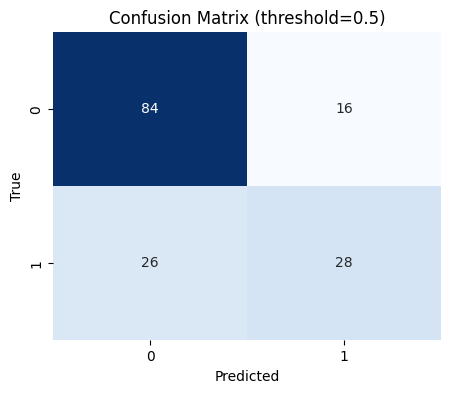

In [70]:
# Apply threshold to probabilities
threshold = 0.5
y_pred_thresh = (y_proba_xgb >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh, labels=[0, 1])

# Plot with seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=[0, 1], yticklabels=[0, 1]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (threshold={threshold})')
plt.show()

## SVM (RBF Kernel)

### Baseline Model

In [71]:
# (1) Instantiate with default settings and probability estimates
svm_baseline = SVC(kernel='rbf', probability=True, random_state=42)

# (2) Scale features (required for SVMs!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# (3) Fit on the full training set
svm_baseline.fit(X_train_scaled, y_train)

# (4) Predict on the test set
y_pred_svm  = svm_baseline.predict(X_test_scaled)
y_proba_svm = svm_baseline.predict_proba(X_test_scaled)[:, 1]

# (5) Print basic metrics
print("SVM Test Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("SVM Test ROC AUC:  ", roc_auc_score(y_test, y_proba_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

SVM Test Accuracy:  0.7532467532467533
SVM Test ROC AUC:   0.7766666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       100
           1       0.68      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



### Hyperparameter Tuning (5-fold CV on training data)

In [72]:
# 1. Pipeline: scaling + SVM (RBF kernel)
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, random_state=42))
])

# 2. Hyperparameter grid to search
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],    # regularization
    'clf__gamma': [0.01, 0.1, 1, 10],     # RBF kernel width
    'clf__class_weight': [None, 'balanced']  # handle imbalance
}

# 3. Set up the grid search
svm_grid = GridSearchCV(
    svm_pipe, param_grid,
    cv=5, scoring='roc_auc',
    n_jobs=-1, verbose=1
)

# 4. Fit on the training data
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__gamma': [0.01, 0.1, 1, 10]},
             scoring='roc_auc', verbose=1)

### Best Parameters

In [73]:
# 5. Get the best model and parameters
print("Best Params:", svm_grid.best_params_)
print("Best CV ROC AUC:", svm_grid.best_score_)

Best Params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01}
Best CV ROC AUC: 0.8424252491694352


### Final Model Training (refit on full training)

In [74]:
# Pull out the refit pipeline (already trained on all of X_train)
best_svm = svm_grid.best_estimator_

# (Optional) Explicitly refit on full training set (not required, but safe)
best_svm.fit(X_train, y_train)

# (2) Predict on test set
y_pred_svm  = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

# (3) Compute metrics
acc_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)

# (4) Print results
print("SVM Test Accuracy: ", acc_svm)
print("SVM Test ROC AUC:  ", auc_svm)

SVM Test Accuracy:  0.7207792207792207
SVM Test ROC AUC:   0.8064814814814815


### Confusion Matrix

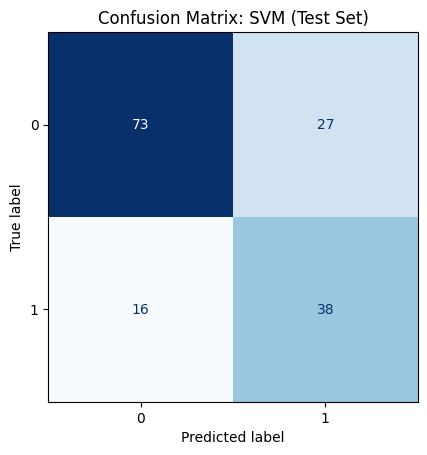

In [75]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', colorbar = False)
disp.ax_.set_title("Confusion Matrix: SVM (Test Set)")
plt.show()

# Comparison

## Model Comparison

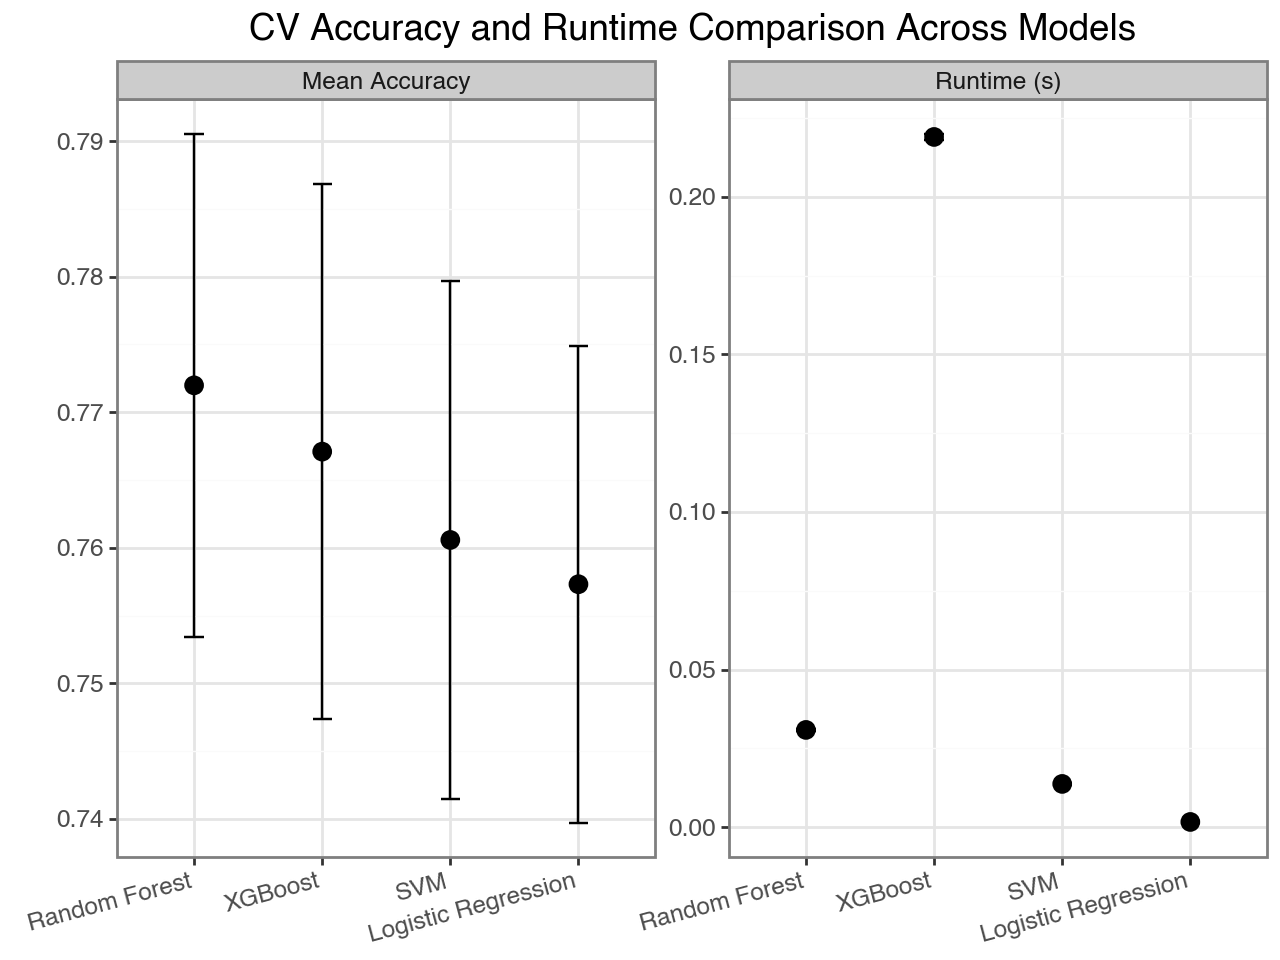

In [76]:
# 1) Define a 5-fold stratified splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) Collect your best pipelines
pipes = {
    "Logistic Regression": lr_grid.best_estimator_,
    "Random Forest":       rf_grid.best_estimator_,
    "XGBoost":             xgb_grid.best_estimator_,
    "SVM":                 svm_grid.best_estimator_
}

# 3) Compute per-fold accuracy and runtime for each model
results = {}
results_runtime = {}
for name, pipe in pipes.items():
    fold_runtimes = []
    fold_scores = []
    for train_idx, test_idx in cv.split(X_train, y_train):
        X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
        start = time.time()
        pipe.fit(X_tr, y_tr)
        score = pipe.score(X_te, y_te)
        end = time.time()
        fold_runtimes.append(end - start)
        fold_scores.append(score)
    results[name] = np.array(fold_scores)
    results_runtime[name] = np.array(fold_runtimes)

# 4) Collect and sort stats by mean accuracy
sorted_stats = sorted(
    [
        (
            name,
            results[name].mean(), results[name].std(),
            results_runtime[name].mean(), results_runtime[name].std()
        )
        for name in results
    ],
    key=lambda x: x[1], reverse=True
)
models, means, stds, mean_times, std_times = zip(*sorted_stats)

# 5) Prepare DataFrame for plotnine faceting
df_long = pd.DataFrame({
    "Model": list(models) * 2,
    "Metric": (["Mean Accuracy"] * len(models)) + (["Runtime (s)"] * len(models)),
    "Value": list(means) + list(mean_times),
    "Error": list(stds) + list(std_times)
})
df_long["Model"] = pd.Categorical(df_long["Model"], categories=models, ordered=True)

# 6) Plot with plotnine
(
    ggplot(df_long, aes(x="Model", y="Value"))
    + geom_point(size=3)
    + geom_errorbar(aes(ymin="Value-Error", ymax="Value+Error"), width=0.15)
    + facet_wrap('~Metric', scales='free_y')
    + labs(title="CV Accuracy and Runtime Comparison Across Models", y="", x="")
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=15, hjust=1))
)

## Metrics

In [77]:
# Build metrics table
metrics = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_svm)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_svm)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_svm)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_svm)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.sort_values(by="ROC AUC", ascending=False)
display(metrics_df)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
1,Random Forest,0.766234,0.645161,0.740741,0.689655,0.818704
2,XGBoost,0.727273,0.636364,0.518519,0.571429,0.815741
3,SVM,0.720779,0.584615,0.703704,0.638655,0.806481
0,Logistic Regression,0.746753,0.615385,0.740741,0.672269,0.805370


## ROC curves

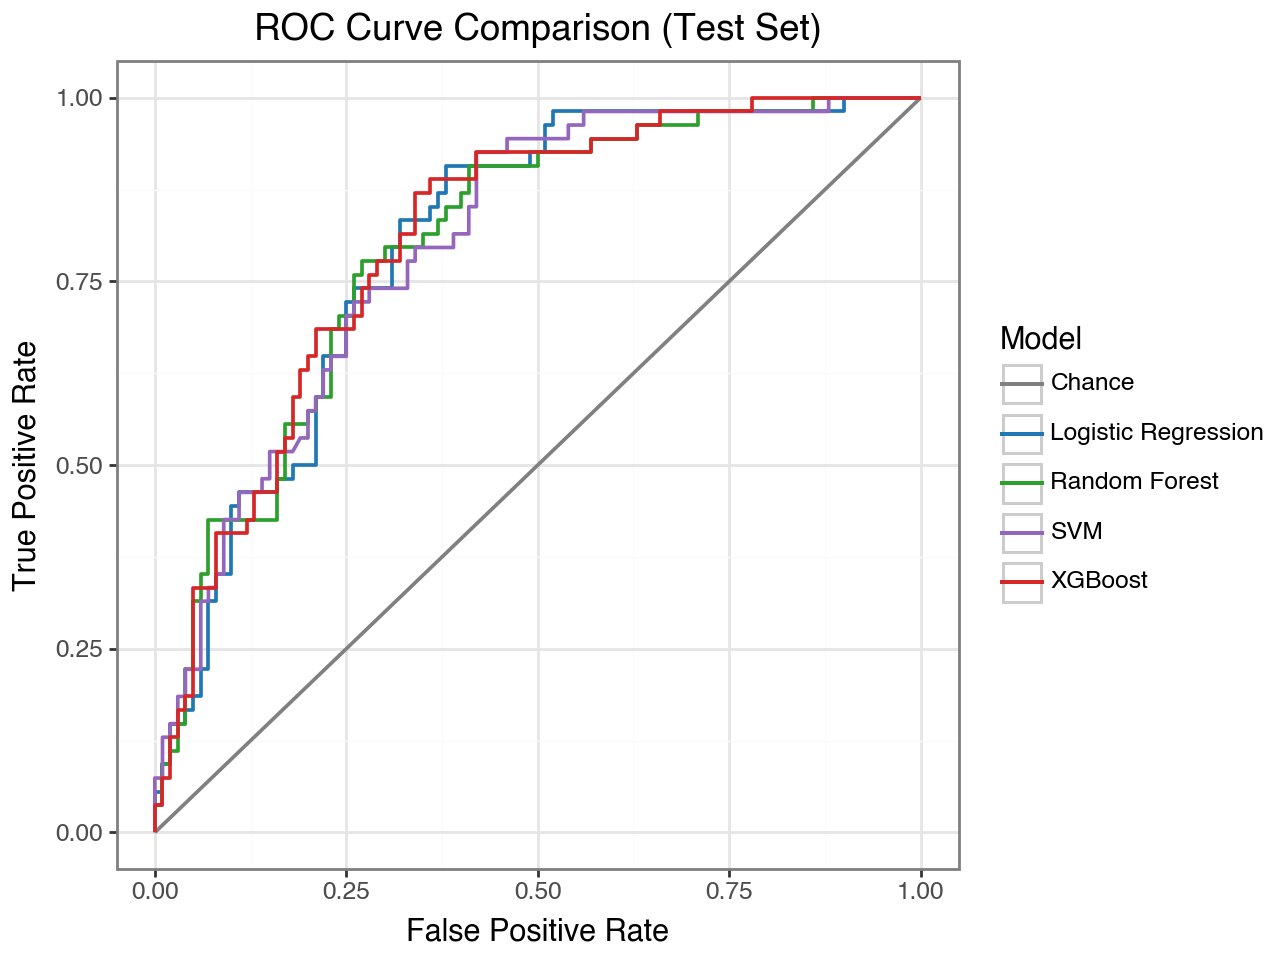

In [78]:
# Build ROC DataFrame row by row

# Logistic Regression
best_lr = lr_grid.best_estimator_
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

# Random Forest
best_rf = rf_grid.best_estimator_
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# XGBoost
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# svm
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

roc_dfs = []
for model_name, fpr, tpr in [
    ("Logistic Regression", fpr_lr, tpr_lr),
    ("Random Forest", fpr_rf, tpr_rf),
    ("XGBoost", fpr_xgb, tpr_xgb), 
    ("SVM", fpr_svm, tpr_svm)
]:
    temp = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'Model': model_name
    })
    roc_dfs.append(temp)

roc_df = pd.concat(roc_dfs, ignore_index=True)

# Add chance line
chance_df = pd.DataFrame({'fpr': [0, 1], 'tpr': [0, 1], 'Model': ["Chance", "Chance"]})
roc_df_all = pd.concat([roc_df, chance_df], ignore_index=True)

from plotnine import ggplot, aes, geom_line, labs, theme_bw, theme, scale_color_manual

(
    ggplot(roc_df_all, aes(x='fpr', y='tpr', color='Model'))
    + geom_line(size=.75)
    + labs(title="ROC Curve Comparison (Test Set)",
           x="False Positive Rate", y="True Positive Rate")
    + scale_color_manual(
        values={"Logistic Regression": "#1f77b4",
                "Random Forest": "#2ca02c",
                "XGBoost": "#d62728",
                "SVM": "#9467bd",
                "Chance": "grey"})
    + theme_bw()
    + theme(legend_position='right')
)



## Feature Importance

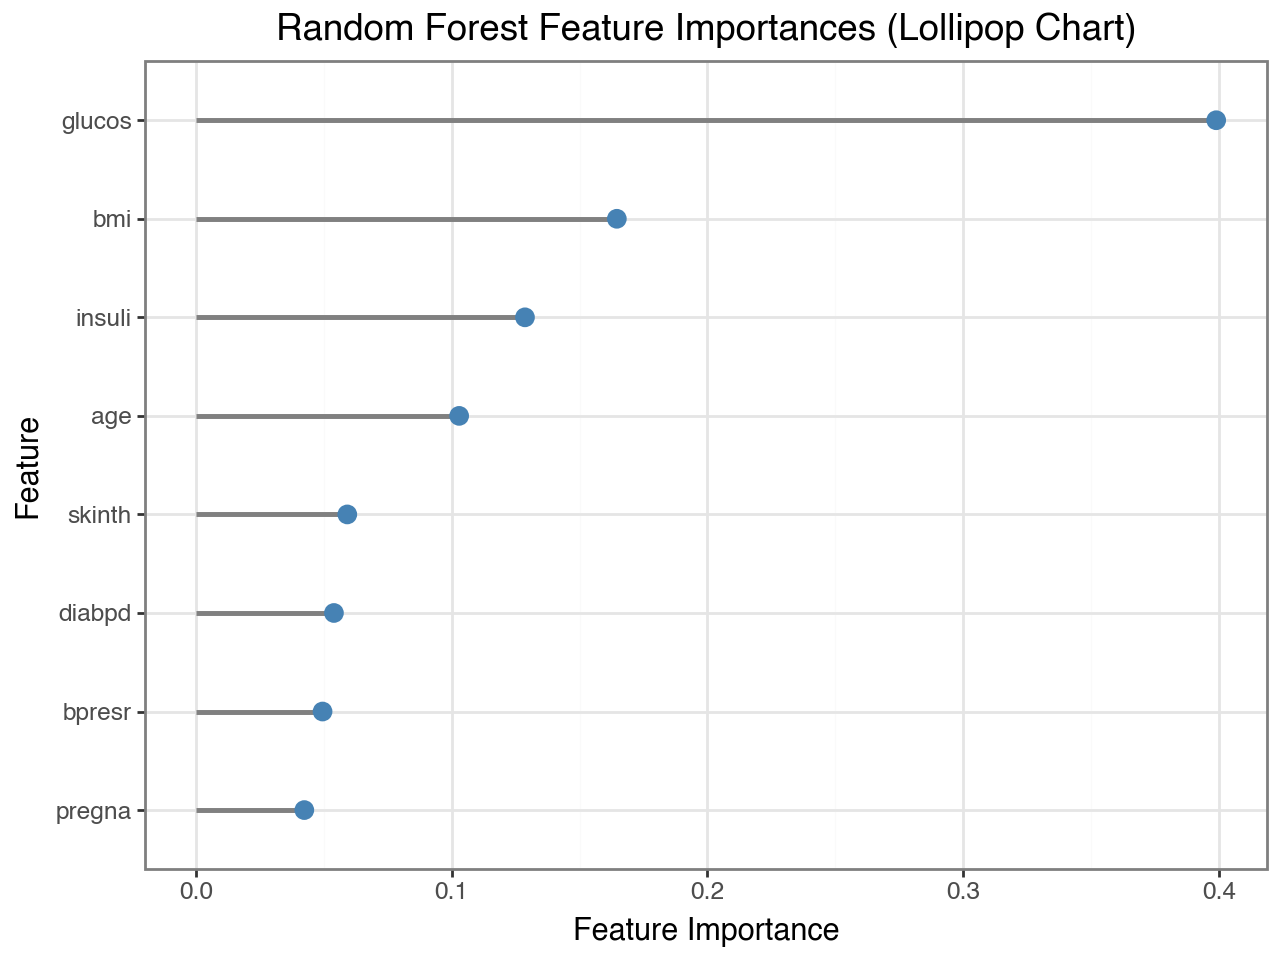

In [79]:
# 1) Extract the fitted RF pipeline
rf_pipe = rf_grid.best_estimator_

# 2) Get feature importances and names, sort descending
importances = rf_pipe.named_steps['clf'].feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# 3) Make 'Feature' a categorical, ordered by importance (largest at top)
importance_df['Feature'] = pd.Categorical(
    importance_df['Feature'],
    categories=importance_df['Feature'][::-1],
    ordered=True
)

from plotnine import ggplot, aes, geom_segment, geom_point, labs, theme_bw, theme, element_text

# 4) Plot as lollipop
(
    ggplot(importance_df, aes(x='Importance', y='Feature'))
    + geom_segment(aes(x=0, xend='Importance', y='Feature', yend='Feature'), color='grey', size=1)
    + geom_point(color='steelblue', size=3)
    + labs(
        title="Random Forest Feature Importances (Lollipop Chart)",
        x="Feature Importance",
        y="Feature"
    )
    + theme_bw()
    + theme(axis_text_y=element_text(ha='right'))
)



# Ensembling

In [80]:
estimators = [
    ('rf', rf_grid.best_estimator_),
    ('xgb', xgb_grid.best_estimator_),
    ('lr', lr_grid.best_estimator_),
    ('svm', svm_grid.best_estimator_)  # Add SVM here!
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
y_proba_stack = stack.predict_proba(X_test)[:, 1]

print("Stacked Test Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacked Test ROC AUC:", roc_auc_score(y_test, y_proba_stack))

Stacked Test Accuracy: 0.7272727272727273
Stacked Test ROC AUC: 0.815


# Error Analysis

## Misclassified

In [81]:
# 1) Make sure X_test is a DataFrame (not a numpy array)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# 2) Build a results table
results = X_test_df.copy()
results['true'] = y_test
results['pred'] = y_pred_rf    # replace with y_pred or y_pred_xgb as needed

# 3) Filter to only the misclassified rows
misclassified = results[results['true'] != results['pred']]

# 4) Inspect
print(f"Total misclassified: {len(misclassified)} / {len(results)}")
misclassified.head(20)

Total misclassified: 36 / 154


,pregna,glucos,bpresr,skinth,insuli,bmi,diabpd,age,true,pred
44,7.0,159.0,64.000000,38.601877,140.304505,27.4,0.294,40.0,0,1
630,7.0,114.0,64.000000,18.714349,74.719840,27.4,0.732,34.0,1,0
335,0.0,165.0,76.000000,43.000000,255.000000,47.9,0.259,26.0,0,1
78,0.0,131.0,63.349649,28.006596,208.680748,43.2,0.270,26.0,1,0
678,3.0,121.0,52.000000,38.655502,136.537425,36.0,0.127,25.0,1,0
660,10.0,162.0,84.000000,31.089309,280.095931,27.7,0.182,54.0,0,1
260,3.0,191.0,68.000000,15.000000,130.000000,30.9,0.299,34.0,0,1
517,7.0,125.0,86.000000,42.742035,282.166559,37.6,0.304,51.0,0,1
437,5.0,147.0,75.000000,22.362716,111.717869,29.9,0.434,28.0,0,1
153,1.0,153.0,82.000000,42.000000,485.000000,40.6,0.687,23.0,0,1


## Misclassifications Compared by Probability

High-confidence misclassifications (proba > 0.7):


,pregna,glucos,bpresr,skinth,insuli,bmi,diabpd,age,true,pred,proba
335,0.0,165.0,76.0,43.000000,255.000000,47.9,0.259,26.0,0,1,0.924754
660,10.0,162.0,84.0,31.089309,280.095931,27.7,0.182,54.0,0,1,0.788565
260,3.0,191.0,68.0,15.000000,130.000000,30.9,0.299,34.0,0,1,0.868805
517,7.0,125.0,86.0,42.742035,282.166559,37.6,0.304,51.0,0,1,0.700911
153,1.0,153.0,82.0,42.000000,485.000000,40.6,0.687,23.0,0,1,0.767819


/var/folders/hm/r4s1x8yd7t3drh0tjd1gkwl00000gn/T/ipykernel_24249/89235516.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/hm/r4s1x8yd7t3drh0tjd1gkwl00000gn/T/ipykernel_24249/89235516.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


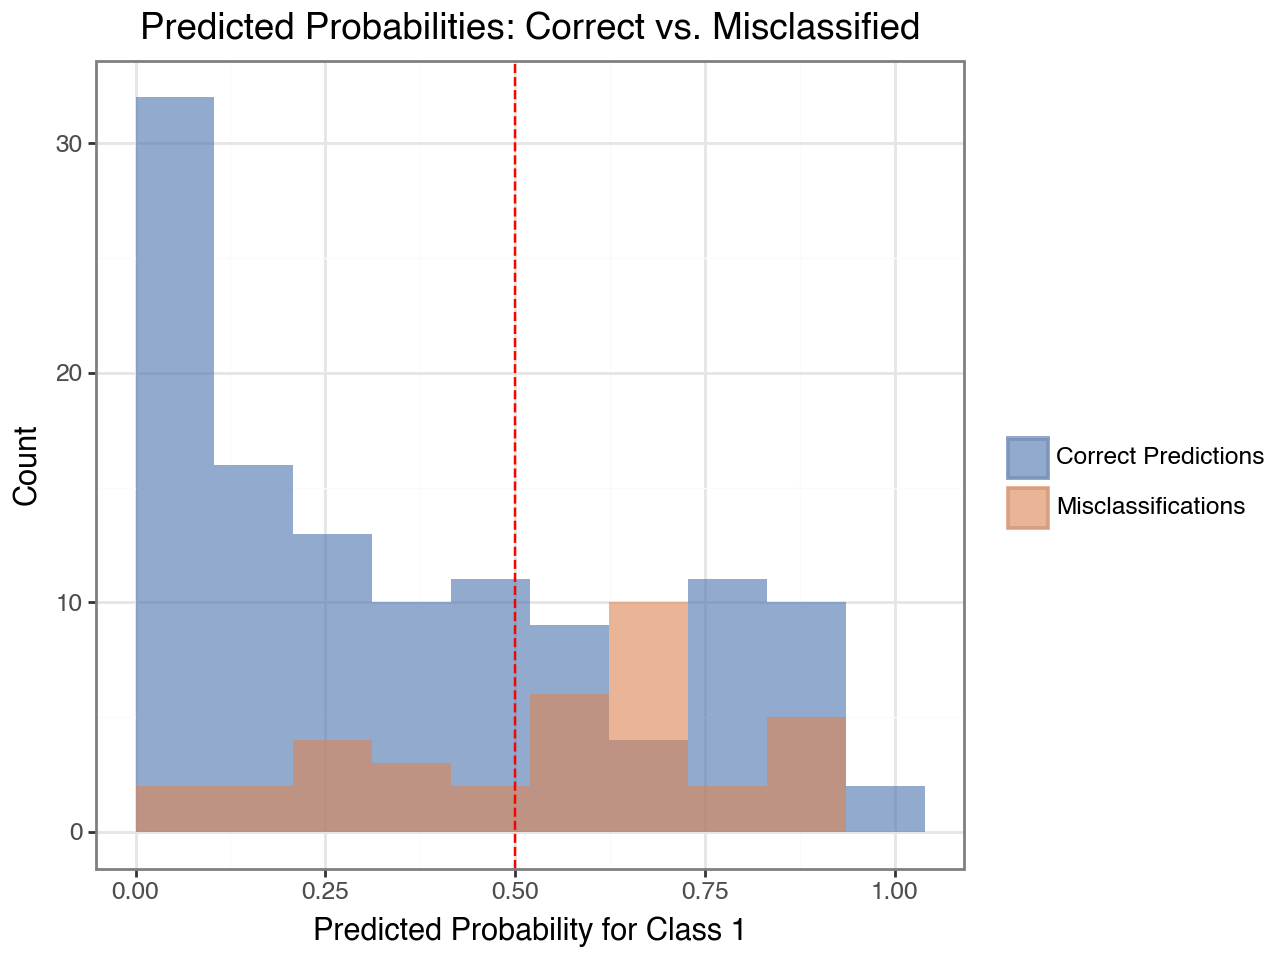

In [82]:
# 1) Convert X_test back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# 2) Build a combined results table
results = X_test_df.copy()
results['true']  = y_test
results['pred']  = y_pred_rf          # model predictions
results['proba'] = y_proba_rf         # predicted probability for the positive class

# 3) Separate misclassified vs. correct
misclassified = results[results['true'] != results['pred']]
correct       = results[results['true'] == results['pred']]

# 4) Quick look at any misclassified cases with high confidence
high_conf_mis = misclassified[misclassified['proba'] > 0.7]
print("High-confidence misclassifications (proba > 0.7):")
display(high_conf_mis.head())

# 5) Combine for ggplot histogram
correct['Category'] = 'Correct Predictions'
misclassified['Category'] = 'Misclassifications'
plot_df = pd.concat([correct, misclassified], axis=0)

# Plot with plotnine
(
    ggplot(plot_df, aes(x='proba', fill='Category'))
    + geom_histogram(
        bins=10,
        alpha=0.6,
        position='identity',  # overlays histograms
        boundary=0
    )
    + geom_vline(xintercept=0.5, linetype='dashed', color='red')
    + scale_fill_manual(values={'Correct Predictions': '#4C72B0', 'Misclassifications': '#DD8452'})
    + labs(
        x='Predicted Probability for Class 1',
        y='Count',
        title='Predicted Probabilities: Correct vs. Misclassified',
        fill=''  # legend title
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=0))
)


## PCA Analysis

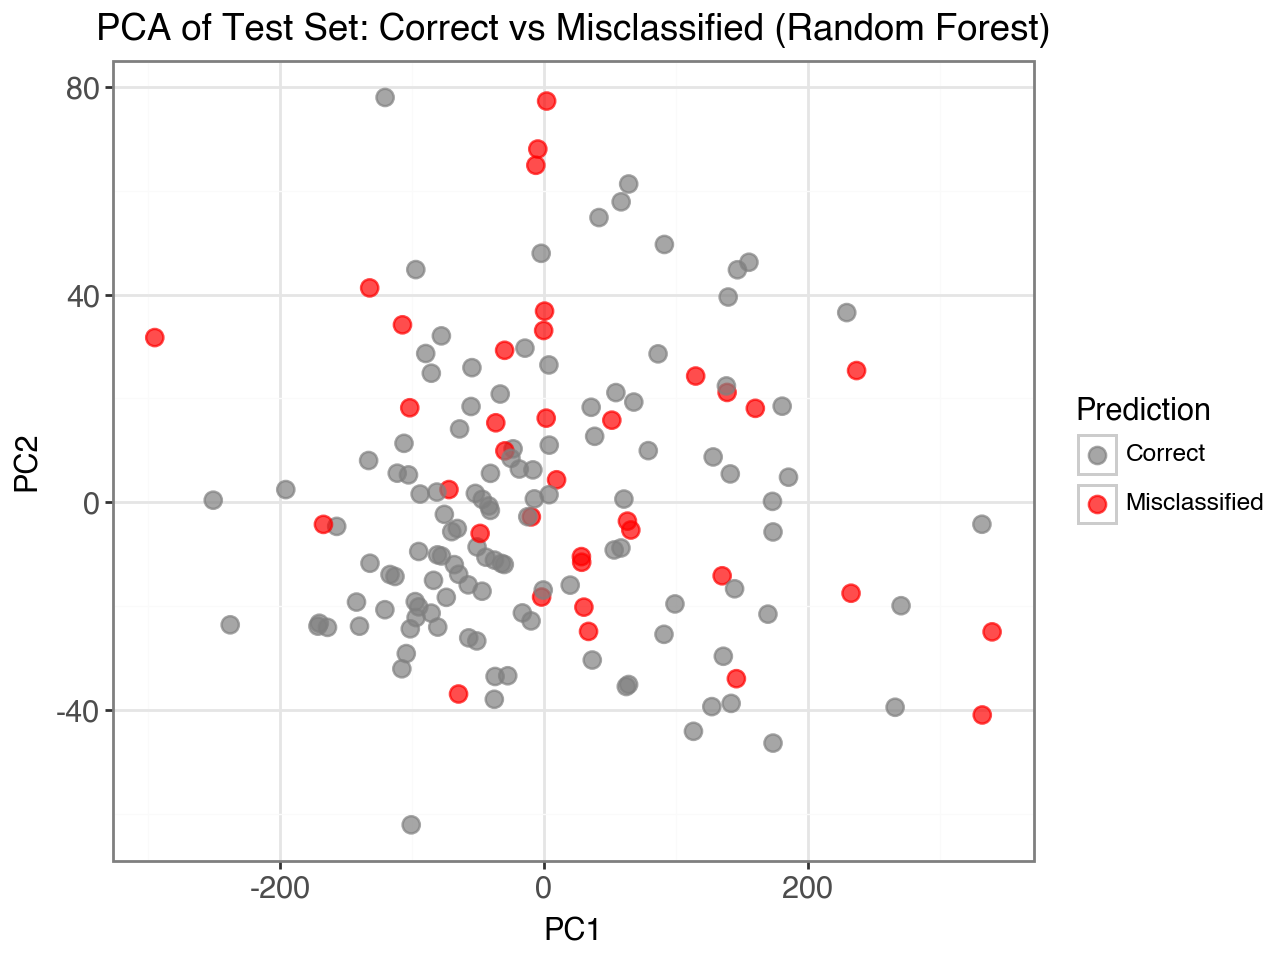

In [83]:
import numpy as np
from sklearn.decomposition import PCA
from plotnine import ggplot, aes, geom_point, labs, scale_color_manual, theme_bw, theme, element_text

# 1) Ensure DataFrame
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# 2) PCA
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_test_df)

# 3) Plotting DataFrame
df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2'])
df_pca['true']  = np.array(y_test)      # Ensures no index alignment issues
df_pca['pred']  = np.array(y_pred_rf)   # Or y_pred_xgb for XGBoost
df_pca['correct'] = df_pca['pred'] == df_pca['true']
df_pca['Status']  = df_pca['correct'].map({True: "Correct", False: "Misclassified"})

# 4) (optional) Print counts
n_correct = df_pca['correct'].sum()
n_total   = len(df_pca)
n_mis     = n_total - n_correct

# 5) Plotnine scatter plot (no assignment, just parentheses)
(
    ggplot(df_pca, aes(x='PC1', y='PC2', color='Status'))
    + geom_point(alpha=0.7, size=3)
    + scale_color_manual(values={"Misclassified": "red", "Correct": "gray"})
    + labs(
        title="PCA of Test Set: Correct vs Misclassified (Random Forest)",
        x="PC1",
        y="PC2",
        color="Prediction"
    )
    + theme_bw()
    + theme(axis_text=element_text(size=11))
)


In [84]:
# 1) Assemble results
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
results = X_test_df.copy()
results['true'] = y_test
results['pred'] = y_pred_rf
results['proba'] = y_proba_rf

# 2) Filter and sort misclassifications by descending confidence
mis = results[results['true'] != results['pred']]
high_conf_mis = mis.sort_values('proba', ascending=False).head(10)

# 3) Display the table
print("Top 10 Misclassifications by Model Confidence")
display(high_conf_mis)


Top 10 Misclassifications by Model Confidence


,pregna,glucos,bpresr,skinth,insuli,bmi,diabpd,age,true,pred,proba
335,0.0,165.0,76.0,43.000000,255.000000,47.9,0.259,26.0,0,1,0.924754
212,7.0,179.0,95.0,31.000000,129.951684,34.2,0.164,60.0,0,1,0.897330
247,0.0,165.0,90.0,33.000000,300.801598,52.3,0.427,23.0,0,1,0.880912
260,3.0,191.0,68.0,15.000000,130.000000,30.9,0.299,34.0,0,1,0.868805
469,6.0,154.0,78.0,41.000000,140.000000,46.1,0.571,27.0,0,1,0.840833
660,10.0,162.0,84.0,31.089309,280.095931,27.7,0.182,54.0,0,1,0.788565
153,1.0,153.0,82.0,42.000000,485.000000,40.6,0.687,23.0,0,1,0.767819
428,0.0,135.0,94.0,46.000000,145.000000,40.6,0.284,26.0,0,1,0.724070
436,12.0,140.0,85.0,33.000000,378.889264,37.4,0.244,41.0,0,1,0.716749
244,2.0,146.0,76.0,35.000000,194.000000,38.2,0.329,29.0,0,1,0.713709
